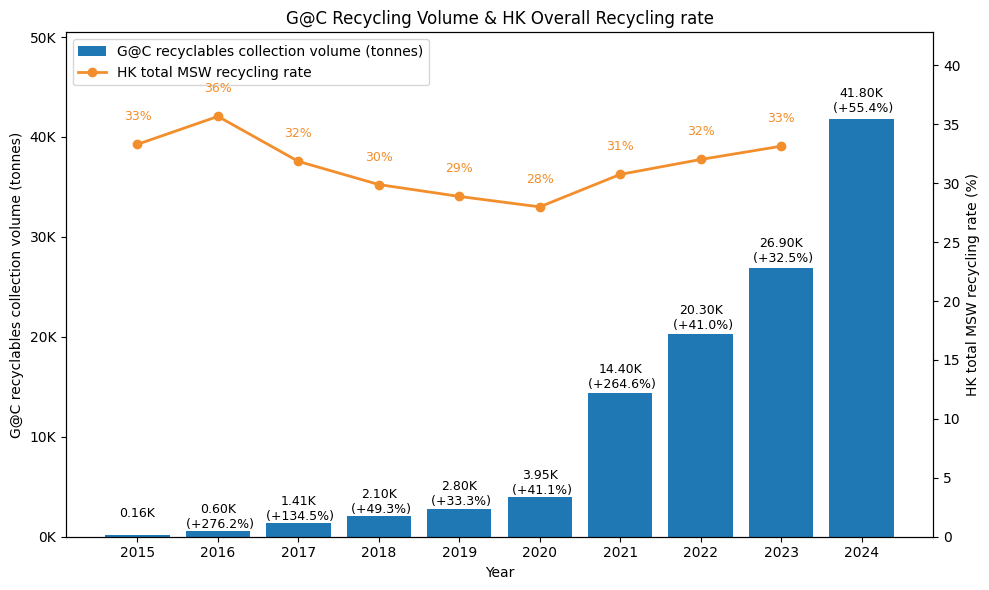

In [3]:
# ==== Install required packages (run these in a terminal, not inside Python) ====
# pip install pandas matplotlib openpyxl

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from pathlib import Path
import math

# -------------------------------------------------------
# 1. Load data from the Excel file
# -------------------------------------------------------
excel_path = "../General Stats_G@C_clean.xlsx"

hk = pd.read_excel(
    excel_path,
    sheet_name="HK MSW Volume and Recycling Rat"
)

# -------------------------------------------------------
# 2. Prepare the relevant data
# -------------------------------------------------------
col_year = "Year"
col_vol  = "G@C recyclables collection volume (tonnes)"
col_rate = "HK total MSW recycling rate"

# take only rows where BOTH year and G@C volume exist
hk_sub = hk[[col_year, col_vol, col_rate]].copy()
mask = hk_sub[col_year].notna() & hk_sub[col_vol].notna()
hk_sub = hk_sub[mask].copy()

# clean year
hk_sub["Year_int"] = hk_sub[col_year].astype(int)

# clean volume (remove commas -> float)
hk_sub["vol_tonnes"] = (
    hk_sub[col_vol]
    .astype(str)
    .str.replace(",", "", regex=False)
    .astype(float)
)

# clean rate: handle both "40%" and 0.40 stored in Excel
rate_raw = (
    hk_sub[col_rate]
    .astype(str)
    .str.replace("%", "", regex=False)
)
rate_vals = pd.to_numeric(rate_raw, errors="coerce")

# if values look like fractions (e.g. 0.33), convert to percentage
mean_rate = rate_vals.dropna().mean()
if mean_rate is not None and mean_rate <= 1:
    rate_vals = rate_vals * 100

hk_sub["rate_percent"] = rate_vals

# sort by year so 2015–2024 are in order
hk_sub = hk_sub.sort_values("Year_int")

years   = hk_sub["Year_int"].tolist()
volumes = hk_sub["vol_tonnes"].tolist()
rates   = hk_sub["rate_percent"].tolist()

# pre-compute year-on-year % change for volumes
vol_pct_change = hk_sub["vol_tonnes"].pct_change() * 100  # first row NaN

# -------------------------------------------------------
# 3. Plot: blue bars (volume) + orange line (rate)
# -------------------------------------------------------
fig, ax1 = plt.subplots(figsize=(10, 6))

x = range(len(years))

# --- Left axis: G@C recycling volume (blue bars) ---
bars = ax1.bar(
    x,
    volumes,
    color="#1f77b4",
    label="G@C recyclables collection volume (tonnes)",
)

ax1.set_xlabel("Year")
ax1.set_ylabel("G@C recyclables collection volume (tonnes)")

# format left Y-axis as e.g. 0K, 5K, 10K ...
def k_formatter(val, pos):
    return f"{int(val / 1000):,}K"

ax1.yaxis.set_major_formatter(FuncFormatter(k_formatter))

ax1.set_xticks(list(x))
ax1.set_xticklabels([str(y) for y in years], rotation=0)

# bar labels: Value (% change), e.g. "0.16K", "0.60K (+275.9%)"
for xi, bar, vol, pct in zip(x, bars, volumes, vol_pct_change):
    vol_k = vol / 1000.0
    value_text = f"{vol_k:.2f}K\n"
    if pd.isna(pct):
        label = value_text
    else:
        label = f"{value_text} ({pct:+.1f}%)"
    ax1.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() * 1.01,
        label,
        ha="center",
        va="bottom",
        fontsize=9,
        color="black",
    )

# extra headroom so labels aren’t cut off
y1_min, y1_max = ax1.get_ylim()
ax1.set_ylim(y1_min, y1_max * 1.15)

# --- Right axis: HK total MSW recycling rate (orange line) ---
ax2 = ax1.twinx()
line_rate, = ax2.plot(
    x,
    rates,                         # now in real % values, e.g. 33, 36...
    color="#f28e2b",
    marker="o",
    linewidth=2,
    label="HK total MSW recycling rate",
)

ax2.set_ylabel("HK total MSW recycling rate (%)")

rate_max = max(rates) if rates else 0
if rate_max <= 0:
    rate_max = 1
# give more vertical room for labels
ax2.set_ylim(0, rate_max * 1.20)

# rate labels above each point: e.g. 33%
rate_offset = rate_max * 0.05   # a bit more space
for xi, r in zip(x, rates):
    if math.isnan(r):
        continue
    ax2.text(
        xi,
        r + rate_offset,
        f"{r:.0f}%",
        ha="center",
        va="bottom",
        fontsize=9,
        color="#f28e2b",
    )

# -------------------------------------------------------
# 4. Legend, title, layout
# -------------------------------------------------------
handles = [bars, line_rate]
labels  = [h.get_label() for h in handles]
ax1.legend(handles, labels, loc="upper left")

plt.title("G@C Recycling Volume & HK Overall Recycling rate")
plt.tight_layout()
plt.show()
